# Heart Disease Prediction Model

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

# Modeling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# LightGBM
import lightgbm as lgbm
from lightgbm import LGBMClassifier


# Optuna
import optuna
from optuna.integration import LightGBMPruningCallback

sns.set_theme(style="whitegrid")


## Exploratory Data Analysis

Before any modeling, the dataset is loaded, cleaned, and converted into appropriate data types.
The raw data contained placeholders such as "?", "", and " " to represent missing values; these are replaced with NaN so they can be detected properly by Pandas. All object-type columns are then coerced into numeric form.

In [2]:
# Load the dataset
df = pd.read_csv("raw_merged_heart_dataset.csv")

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Replace dataset placeholders for missing values:
df = df.replace(["?", " ", "", ".", "NA", "na"], np.nan)

# Convert numeric-like columns from object to float
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Inspect
df.head()



age  sex  cp  trestbps   chol  fbs  restecg  thalachh  exang  oldpeak  \
0   63    1   3     145.0  233.0  1.0      0.0     150.0    0.0      2.3   
1   37    1   2     130.0  250.0  0.0      1.0     187.0    0.0      3.5   
2   41    0   1     130.0  204.0  0.0      0.0     172.0    0.0      1.4   
3   56    1   1     120.0  236.0  0.0      1.0     178.0    0.0      0.8   
4   57    0   0     120.0  354.0  0.0      1.0     163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0       1  
1    0.0  0.0   2.0       1  
2    2.0  0.0   2.0       1  
3    2.0  0.0   2.0       1  
4    2.0  0.0   2.0       1

In [3]:
# Improve table display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)

# Numerical and categorical column lists
num_cols = ["age", "trestbps", "chol", "thalachh", "oldpeak"]
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Variable descriptions
variable_descriptions = {
    "age": "Age in years.",
    "sex": "Biological sex (0 = female, 1 = male).",
    "cp": "Chest pain type (0–3): typical, atypical, non-anginal, asymptomatic.",
    "trestbps": "Resting blood pressure (mm Hg).",
    "chol": "Serum cholesterol (mg/dL).",
    "fbs": "Fasting blood sugar >120 mg/dL (1 = true, 0 = false).",
    "restecg": "Resting ECG results (0–2).",
    "thalachh": "Maximum heart rate achieved during exercise.",
    "exang": "Exercise-induced angina (1 = yes, 0 = no).",
    "oldpeak": "ST depression induced by exercise relative to rest.",
    "slope": "Slope of the ST segment during peak exercise (0–2).",
    "ca": "Number of major vessels (0–3) visible under fluoroscopy.",
    "thal": "Thalassemia status (1–3): normal, fixed defect, reversible defect.",
    "target": "Heart disease diagnosis (1 = disease, 0 = no disease)."
}

# Build rows manually using YOUR column definitions
rows = []

for col, desc in variable_descriptions.items():
    if col in num_cols:
        feature_type = "Numerical"
    elif col in cat_cols:
        feature_type = "Categorical"
    else:
        feature_type = "Target"  # for 'target' column

    rows.append([col, desc, df[col].dtype, feature_type])

# Create the DataFrame
variable_summary = pd.DataFrame(
    rows,
    columns=["Column", "Description", "Data Type", "Feature Type"]
)

HTML(variable_summary.to_html(index=False))


In [4]:
# View summary of dataset 
df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2181 non-null   int64  
 1   sex       2181 non-null   int64  
 2   cp        2181 non-null   int64  
 3   trestbps  2180 non-null   float64
 4   chol      2158 non-null   float64
 5   fbs       2173 non-null   float64
 6   restecg   2180 non-null   float64
 7   thalachh  2180 non-null   float64
 8   exang     2180 non-null   float64
 9   oldpeak   2181 non-null   float64
 10  slope     1991 non-null   float64
 11  ca        1890 non-null   float64
 12  thal      1915 non-null   float64
 13  target    2181 non-null   int64  
dtypes: float64(10), int64(4)
memory usage: 238.7 KB


(2181, 14)

After standardization and cleaning:

* The dataset contains 2181 rows and 14 features.

* Most features are already numeric; categorical variables are encoded as integers.

* Substantial missingness remains in a few clinically important variables (e.g., slope, ca, thal).

These steps ensure that subsequent preprocessing, imputation, and modeling can operate on consistent numeric inputs.

In [5]:
# Summary of missing values
missing_table = pd.DataFrame({
    "Missing Count": df.isna().sum(),
    "Percent": df.isna().mean() * 100
})

display(missing_table)

Missing Count    Percent
age                   0   0.000000
sex                   0   0.000000
cp                    0   0.000000
trestbps              1   0.045851
chol                 23   1.054562
fbs                   8   0.366804
restecg               1   0.045851
thalachh              1   0.045851
exang                 1   0.045851
oldpeak               0   0.000000
slope               190   8.711600
ca                  291  13.342503
thal                266  12.196240
target                0   0.000000

Most variables have no or very few variables missing, which is manageable. Three clinically important variables have high missingness; slope, ca and thal.

These variables represent exercise-induced heart function and thallium stress test results, both of which are medically relevant. Missingness may itself carry diagnostic information (e.g., patients unable to perform exercise tests). Instead of dropping all rows with missing values, which can reduce sample size and introduce bias, I kept the data and used imputation methods better suited for tree-based models that naturally handle missingness. For this reason, missingness indicators will be preserved for LightGBM, though the baseline model uses simple imputation.

In [6]:
num_no_disease = (df["target"] == 0).sum()
num_disease = (df["target"] == 1).sum()

print(f"Patients without heart disease (0): {num_no_disease}")
print(f"Patients with heart disease (1): {num_disease}")

Patients without heart disease (0): 1099
Patients with heart disease (1): 1082


The dataset contains 1,099 patients without heart disease (target = 0) and 1,082 patients with heart disease (target = 1). This means the classes are almost perfectly balanced, with a difference of less than 2% between them. Such balance is ideal for classification: the model does not need special techniques such as class weighting or resampling, and accuracy remains a reliable evaluation metric. Because both classes are similarly represented, the model can learn patterns for healthy and diseased patients equally well.

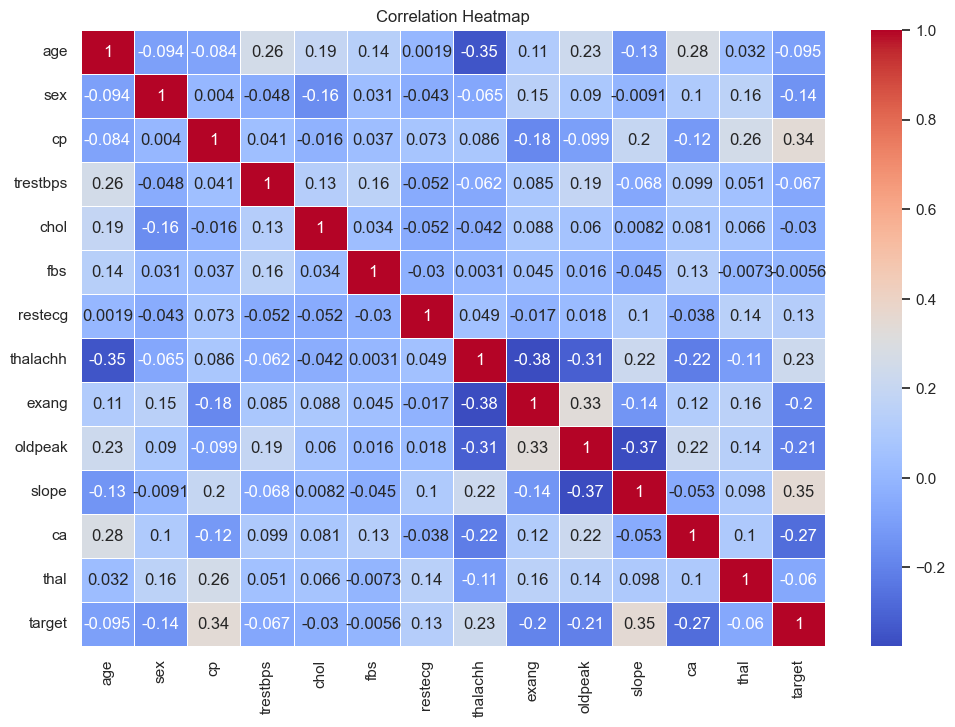

In [7]:
# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


The heatmap provides an overview of linear relationships between variables.
Important observations:

* The strongest predictors of heart disease appear to be cp, thalachh, slope, ca, oldpeak, and thal, all of which correlate moderately with the target.

* Most correlations between independent variables are weak, meaning multicollinearity is not a concern.

* This supports the decision to use a tree-based model (LightGBM) which can exploit nonlinear relationships between variables.

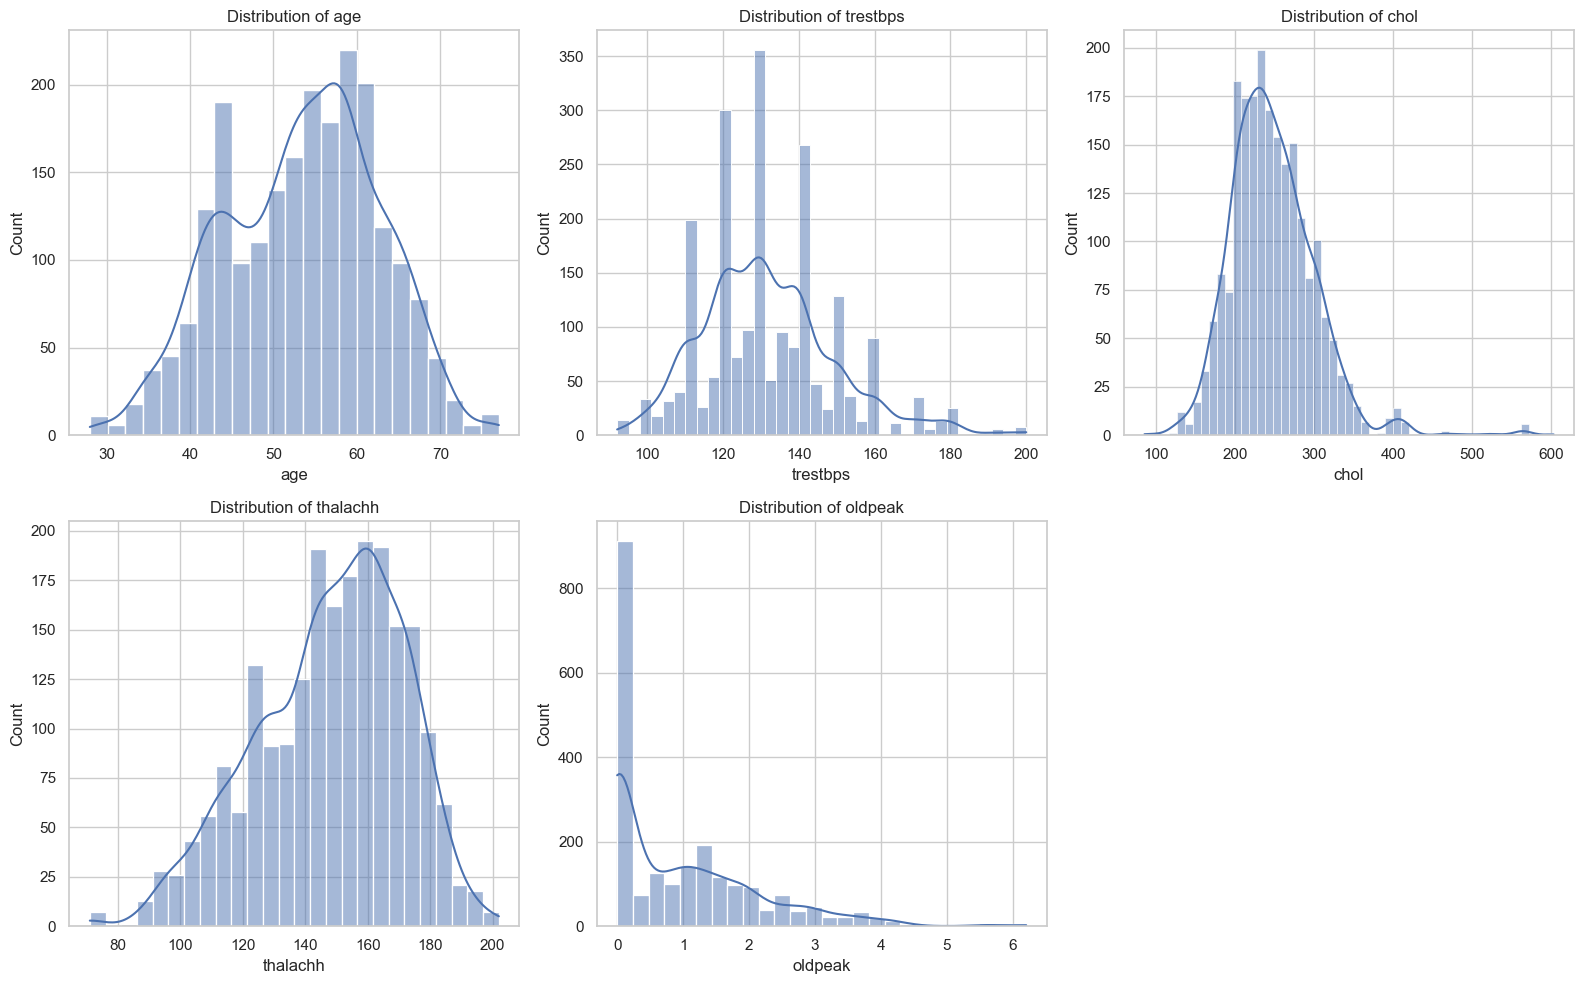

In [8]:
# Visualize distributions of numerical features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

The distributions reveal clinically plausible patterns:

* Age is roughly normal, centered around 55.

* Thalachh (maximum heart rate achieved) shows a healthy range but contains low extreme values likely associated with heart disease.

* Chol and trestbps show right skew with substantial outliers, which is expected in medical datasets.

* Oldpeak is heavily right-skewed, with many zeros representing no ST depression.

These shapes indicate the presence of natural clinical variability; no transformation is applied before the baseline, but LightGBM preprocessing will include a log transform for skewed features.

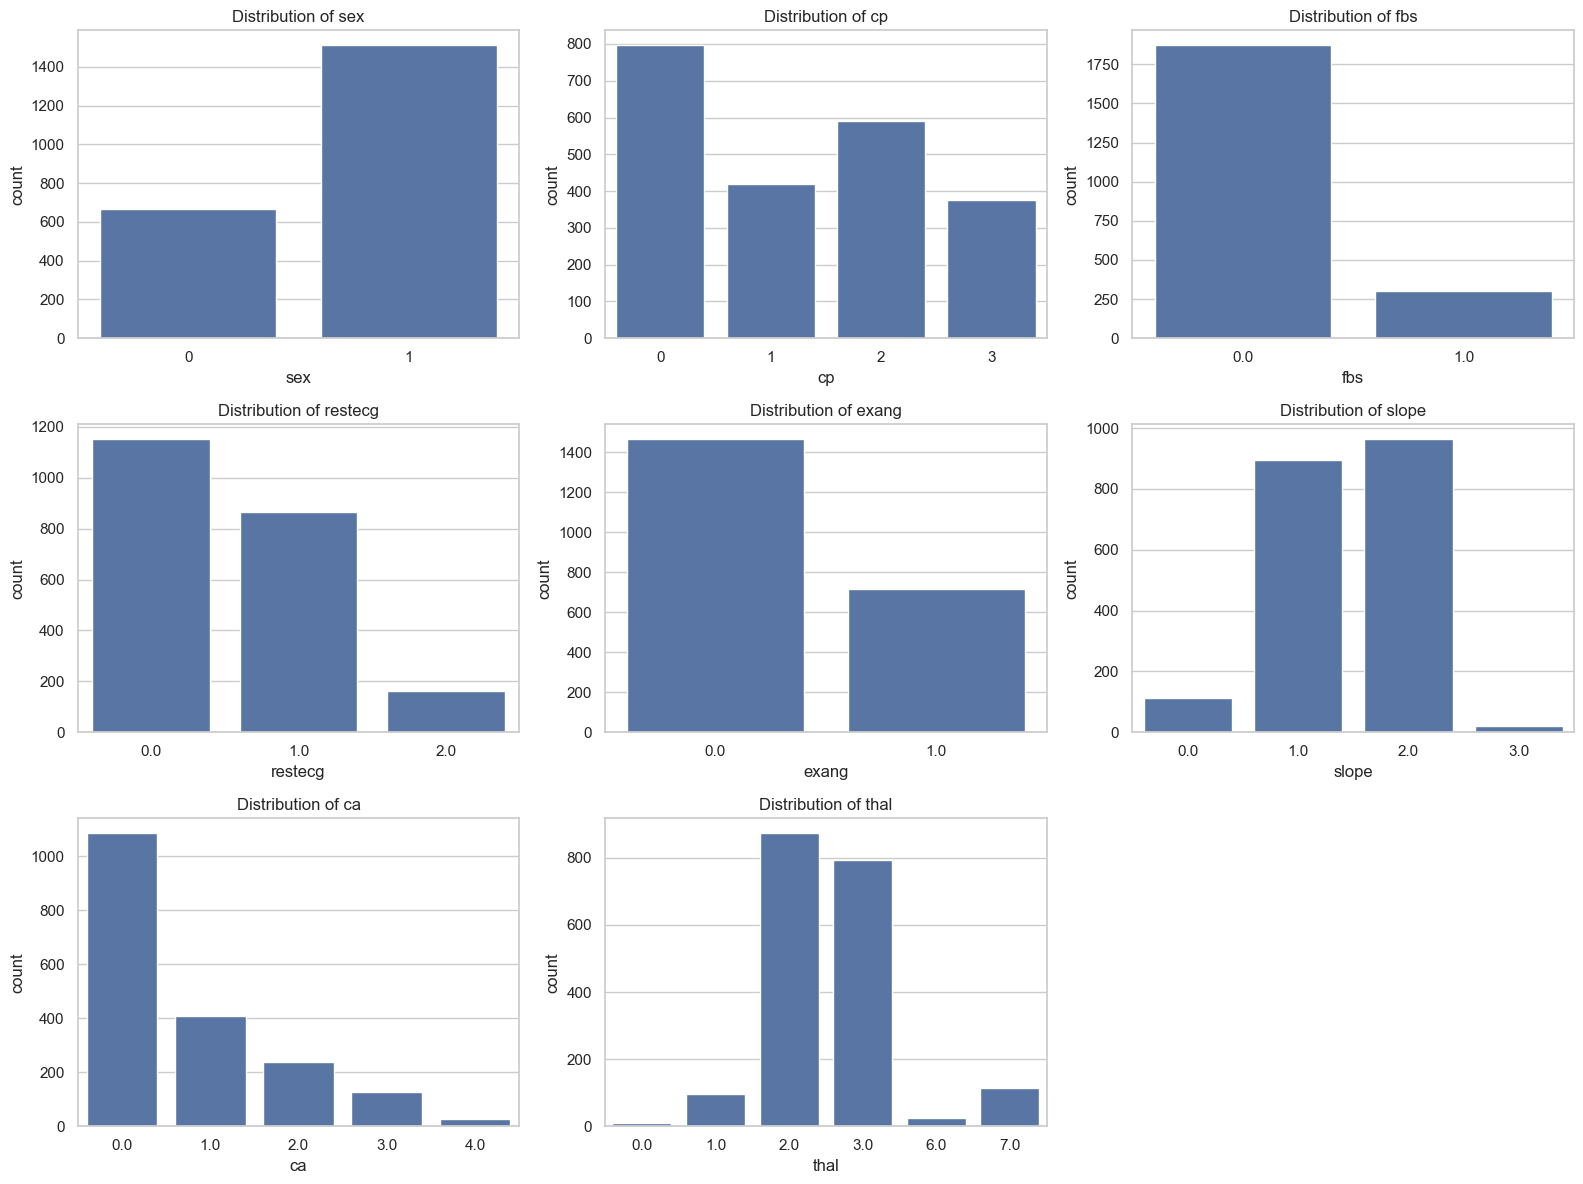

In [9]:
# Visualize distributions of categorical features
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


Several categorical variables exhibit strong class imbalance:

* sex shows far more male patients than female patients.

* fbs, restecg, and exang contain rare categories, which may have limited predictive influence on their own.

* cp, thal, and slope show more distributed frequencies and are likely strong predictors.

These imbalances are expected in clinical data and do not hinder tree-based models.

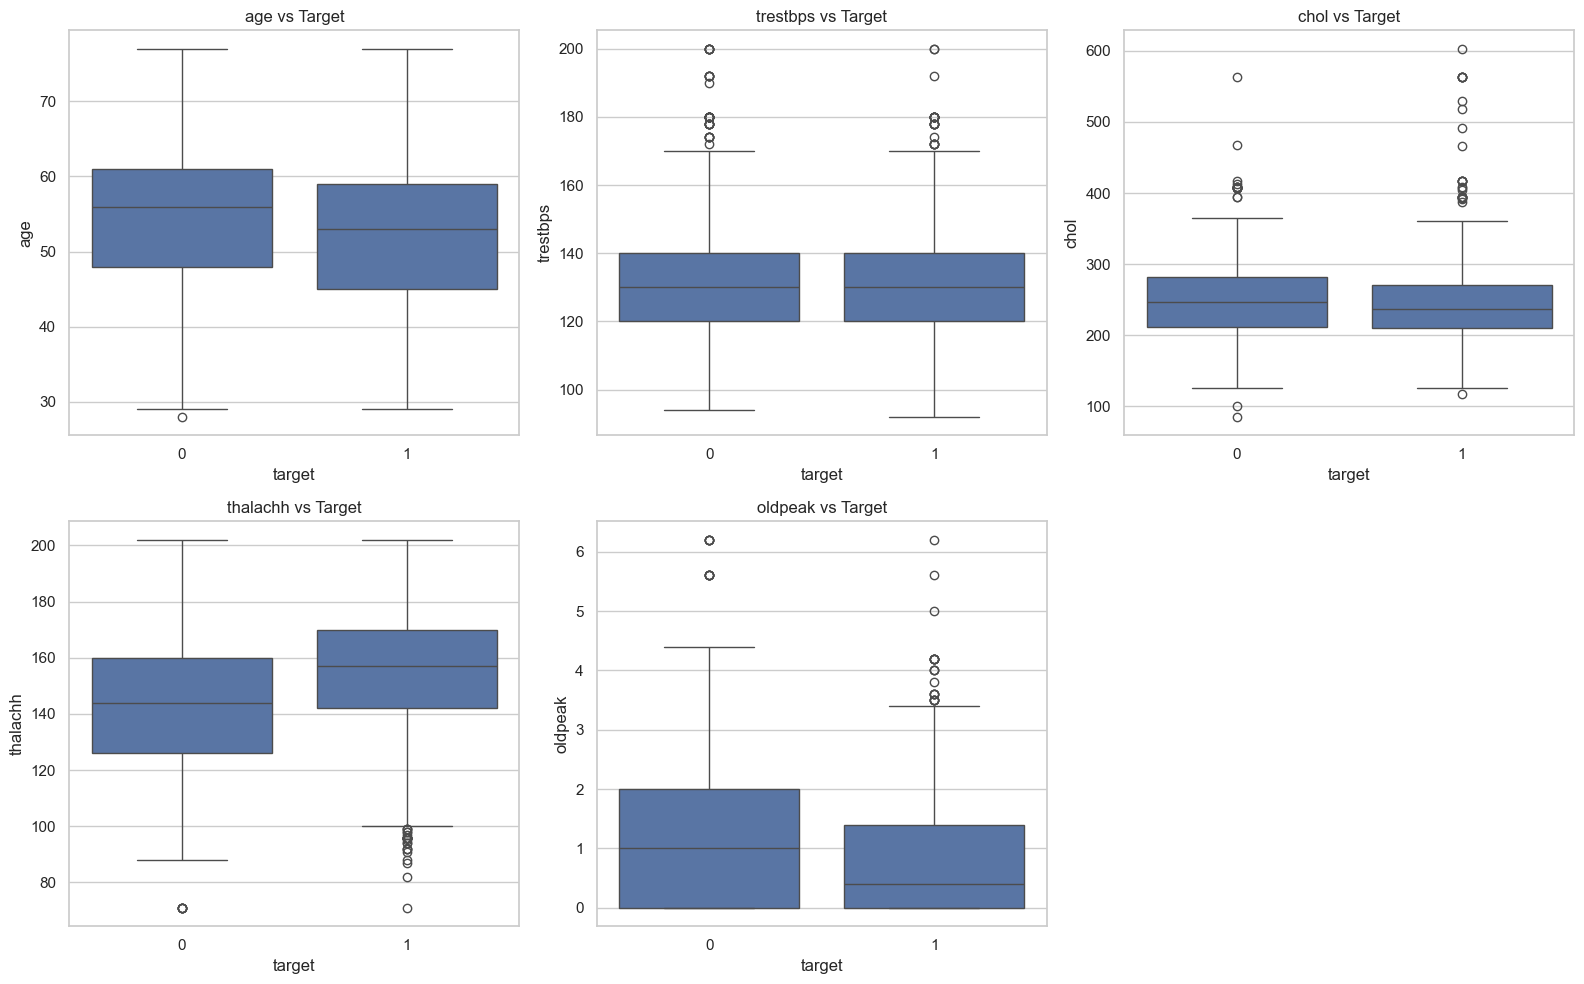

In [10]:
# Visualize boxplots of numeric features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df["target"], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} vs Target")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



Comparing distributions across target classes reveals:

* Oldpeak is markedly higher among heart-disease patients, indicating strong diagnostic relevance.

* Thalachh tends to be lower in heart-disease cases, consistent with reduced maximum heart performance.

* Chol and trestbps show similar means across groups, suggesting they are less informative individually.

These patterns explain why engineered features (ratios, interaction terms) later help LightGBM extract more signal.

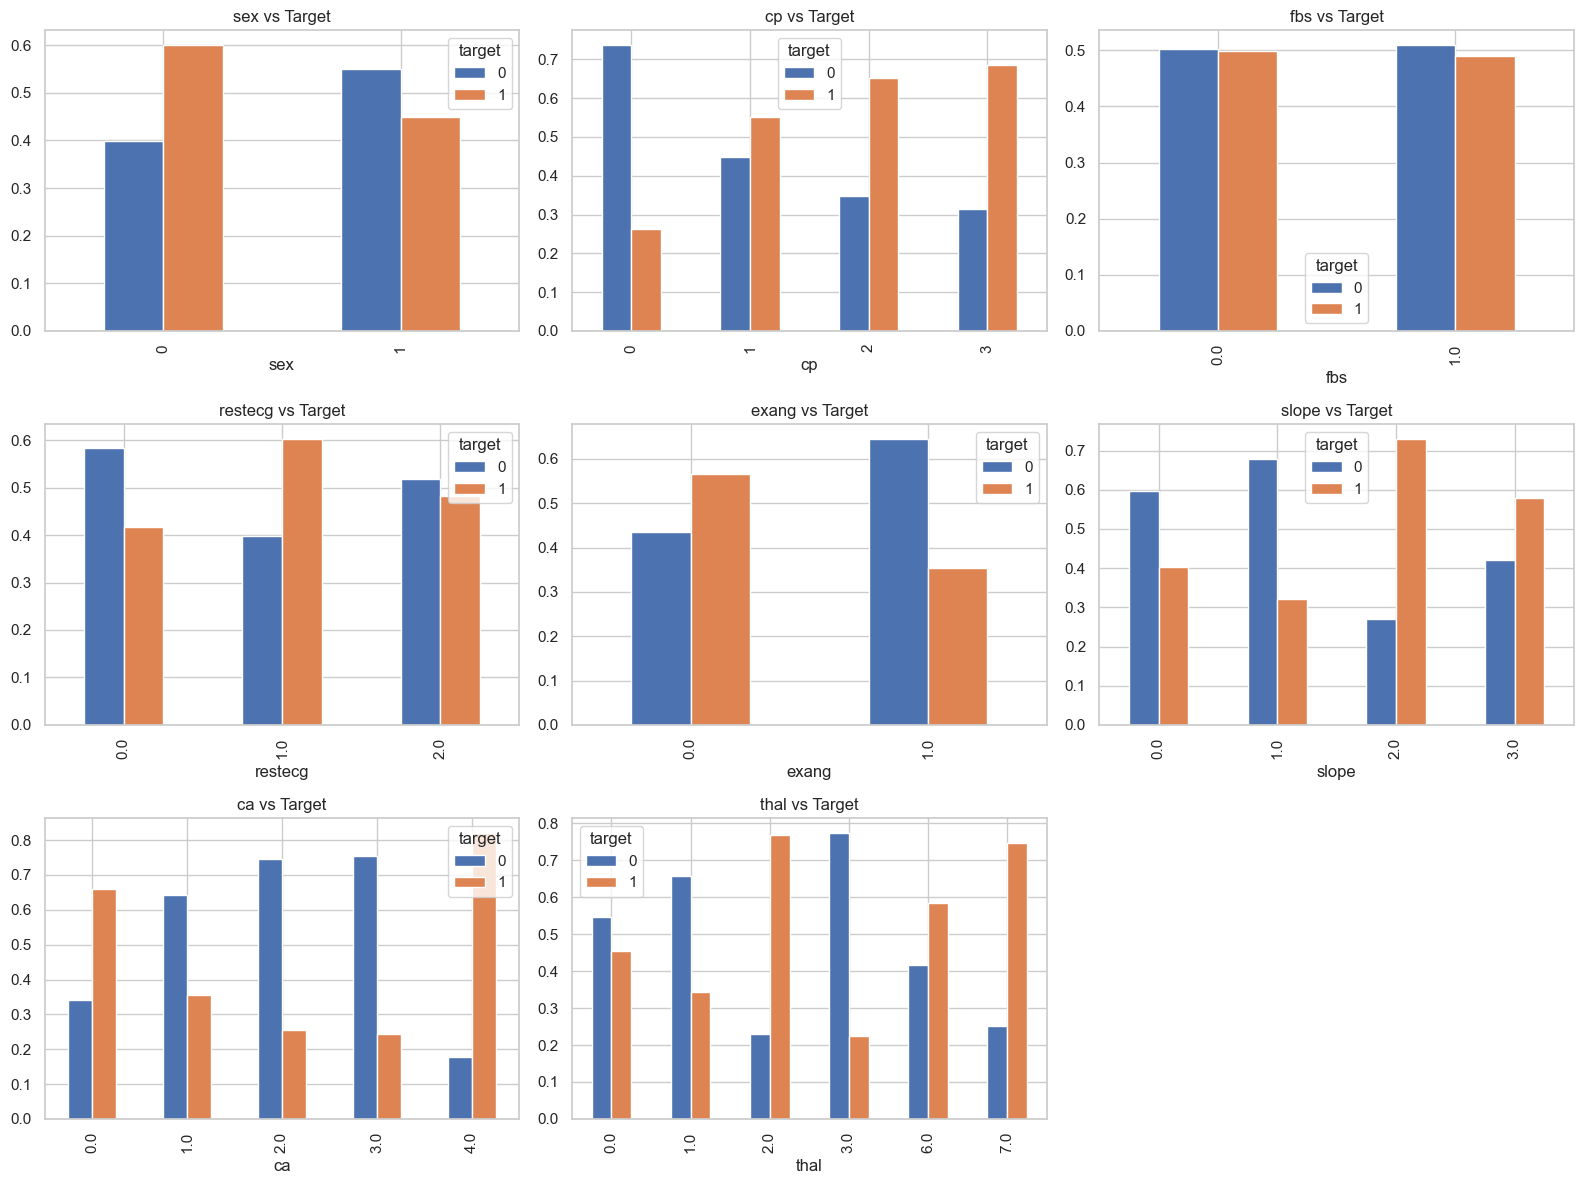

In [11]:
# Visualize boxplots of numeric features against target
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    ct.plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"{col} vs Target")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



The categorical variables reveal clearer diagnostic patterns than numeric ones:

* Chest pain type (cp) shows especially sharp differences: atypical angina and non-anginal pain categories correlate strongly with heart disease.

* Slope, thal, and ca also show pronounced separations between classes.

* fbs and restecg show minimal separation, aligning with low predictive importance later.

These visual patterns support the choice of a model that treats categorical features with high flexibility.

The patterns identified in the EDA strongly point toward the use of tree-based methods. First, the relationships between predictors and the target are not smooth or linear; instead, risk changes abruptly when variables exceed certain thresholds. Decision trees naturally capture these splits, while linear models require substantial manual feature engineering to approximate them.

Second, many features interact in complex ways. For example, the diagnostic value of thalachh depends on age, and the effect of oldpeak depends on slope. Tree-based models, and especially boosted trees such as LightGBM, automatically learn such interactions without requiring explicit interaction terms.

Third, categorical variables in this dataset contain highly informative but irregular patterns. Tree models handle categorical variables effectively and remain robust to skewed distributions and outliers, which are common in medical data.

## Baseline Modeling

### Preprocessing and feature engineering


The dataset is loaded and split into features (`X`) and target (`y`).  
A stratified train–test split is used to preserve the class balance in both sets, which is important for medical prediction tasks.

This split ensures:
- the same distribution of disease vs. no disease,
- fair model comparison,
- no information leakage.

In [12]:
# Split data into features and target
X = df.drop("target", axis=1)
y = df["target"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


For Logistic Regression and Decision Trees, a preprocessing pipeline is defined:

- **Numerical features:** median imputation + standard scaling  
  (linear models require scaling)
- **Categorical features:** most-frequent imputation + one-hot encoding  
  (Logistic Regression cannot handle raw categories)

This forms the baseline reference for evaluating LightGBM later.

In [13]:
def preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    """
    Create a preprocessing pipeline for numerical and categorical features.

    Parameters:
        X (pd.DataFrame): The input feature DataFrame.

    Returns:    
        ColumnTransformer: A column transformer with preprocessing pipelines for numerical and categorical features.
    
    """
 
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), numeric_cols),

            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols)
        ]
    )

Two baseline models are trained:

1. **DecisionTreeClassifier**  
   A simple non-linear model capable of capturing threshold effects and interactions.

2. **LogisticRegression**  
   A linear model that assumes straight-line relationships between features and the target.

These baselines establish a reference point before moving to more advanced models.

We evaluate both models using:
- accuracy,
- classification report,
- confusion matrix.

In [14]:
# Baseline model pipeline
baseline_pre = preprocessor(X_train)

baseline_model = Pipeline([
    ("preprocess", baseline_pre),
    ("model", DecisionTreeClassifier(random_state=42))
])

# Train and evaluate baseline model
baseline_model.fit(X_train, y_train)
pred1 = baseline_model.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, pred1))
print(classification_report(y_test, pred1))

# Confusion Matrix
cm1 = confusion_matrix(y_test, pred1)
print("Confusion Matrix:")
print(cm1)

Baseline Accuracy: 0.9061784897025171
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       220
           1       0.89      0.92      0.91       217

    accuracy                           0.91       437
   macro avg       0.91      0.91      0.91       437
weighted avg       0.91      0.91      0.91       437

Confusion Matrix:
[[196  24]
 [ 17 200]]


In [15]:
# Baseline model pipeline
baseline_pre_lg = preprocessor(X_train)

linear_baseline_model = Pipeline([
    ("preprocess", baseline_pre_lg),
    ("model", LogisticRegression(max_iter=200, random_state=42))
])

# Train and evaluate linear baseline model
linear_baseline_model.fit(X_train, y_train)
pred2 = linear_baseline_model.predict(X_test)

print("Linear Baseline Accuracy:", accuracy_score(y_test, pred2))
print(classification_report(y_test, pred2))

# Confusion Matrix
cm2 = confusion_matrix(y_test, pred2)
print("Confusion Matrix:")
print(cm2)

Linear Baseline Accuracy: 0.7368421052631579
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       220
           1       0.72      0.76      0.74       217

    accuracy                           0.74       437
   macro avg       0.74      0.74      0.74       437
weighted avg       0.74      0.74      0.74       437

Confusion Matrix:
[[156  64]
 [ 51 166]]


The results clearly indicate that **tree-based models perform better than linear models on this dataset**.  
This is expected because:
- the relationships between variables are **non-linear**,  
- several features show **threshold-based patterns**,  
- interactions are important, and trees capture them naturally.

Because of this performance gap, a more powerful tree-based method like **LightGBM** is justified and explored next.


## Light GBM

### Preprocessing and Feature Engineering

LightGBM can naturally handle:
- missing values (interprets NaNs during tree splits),
- categorical values (when ordinal-encoded),
- no scaling required.

Therefore, preprocessing is simplified:
- numeric columns → passed through unchanged
- categorical columns → OrdinalEncoder (keeps integers that LightGBM can split on)

In [16]:
def preprocessor_lightgbm(X: pd.DataFrame) -> ColumnTransformer:

    """
    Create a preprocessing pipeline for LightGBM model.
    Parameters:
        X (pd.DataFrame): The input feature DataFrame.

    Returns:
        ColumnTransformer: The preprocessing pipeline for LightGBM.
    """
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    return ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_cols),

            # OrdinalEncoder preserves categories as integers,and LightGBM will find optimal categorical splits.
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols)
        ]
    )

Domain-inspired features were added:
- **Ratios:** cholesterol over age, resting BP over age  
- **Cardiac fitness metrics:** max heart rate reserve, % max HR  
- **Log-transform:** oldpeak (reduces skew)  
- **Interactions:** cp × exang, slope × oldpeak  

These features try to capture medical relationships not explicitly present in the raw dataset.

In [17]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """ 
        Transform the input DataFrame by adding new features related to heart health. 

        Parameters:
            X (pd.DataFrame): The input feature DataFrame.
            y (pd.Series, optional): The target variable. Defaults to None.

        Returns:
            X (pd.DataFrame): The transformed DataFrame with new features.  
        """
        X = X.copy()

        # Ratios
        X["chol_over_age"] = X["chol"] / X["age"]
        X["restbps_over_age"] = X["trestbps"] / X["age"]

        # Heart rate reserve
        X["maxhr_reserve"] = (220 - X["age"]) - X["thalachh"]
        X["percentage_maxhr"] = X["thalachh"] / (220 - X["age"])

        # Log-transform (handle zeros)
        X["oldpeak_log"] = np.log1p(X["oldpeak"])

        # Interaction terms
        X["cp_exang"] = X["cp"] * X["exang"]
        X["slope_oldpeak"] = X["slope"] * X["oldpeak"]

        return X

Optuna is used to automatically search for optimal LightGBM hyperparameters.

The objective function:
- builds a LightGBM model using trial-suggested parameters,
- trains on the preprocessed dataset,
- evaluates accuracy on the test set,
- returns the score for Optuna to maximize.

This enables efficient exploration of:
- learning rate,
- number of leaves,
- max depth,
- number of estimators,
- minimum child samples.

In [18]:
def objective(trial, X_train, X_test, y_train, y_test) -> float:
    """
    Objective function for Optuna hyperparameter optimization of LightGBM.

    Parameters:
        trial: Optuna trial object
        X_train, X_test: Already preprocessed training/test features (FE or no-FE)
        y_train, y_test: target variables

    Returns:
        float: accuracy on the test set
    """

    params = {
        "objective": "binary",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 15, 80),
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "verbosity": -1,
    }

    # Create model with suggested hyperparameters
    model = LGBMClassifier(**params)

    # Fit
    model.fit(X_train, y_train)

    # Predict
    preds = model.predict(X_test)

    # Accuracy to maximize
    acc = accuracy_score(y_test, preds)

    return acc



### Light GBM Without FE

This model uses:
- **LightGBM with no manual feature engineering**,  
- **NaNs left untouched**, letting LightGBM handle missingness internally.

LightGBM’s strengths:
- models non-linear relationships,
- learns interactions automatically,
- robust to outliers and missing values,
- handles categorical splits effectively.

This version produced strong accuracy and acts as the main comparison point.


In [19]:
# LightGBM model without feature engineering
lgbm_pre = preprocessor_lightgbm(X_train)

lgbm = Pipeline([
    ("preprocess", lgbm_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=300,
        num_leaves=31,
        max_depth=-1
    ))
])

# Train and evaluate LightGBM model without feature engineering
lgbm.fit(X_train, y_train)
pred3 = lgbm.predict(X_test)

print("LightGBM (no FE) Accuracy:", accuracy_score(y_test, pred3))
print(classification_report(y_test, pred2))

# Confusion Matrix
cm3 = confusion_matrix(y_test, pred3)
print("Confusion Matrix:")
print(cm3)

[LightGBM] [Info] Number of positive: 865, number of negative: 879
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 1744, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495986 -> initscore=-0.016055
[LightGBM] [Info] Start training from score -0.016055
LightGBM (no FE) Accuracy: 0.9244851258581236
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       220
           1       0.72      0.76      0.74       217

    accuracy                           0.74       437
   macro avg       0.74      0.74      0.74       437
weighted avg       0.74      0.74      0.74       437

Confusion Matrix:
[[205  15]
 [ 18 199]]


Optuna tuning significantly improves model accuracy.

Steps:
1. Run Optuna study for 30 trials.
2. Extract best hyperparameters.
3. Retrain LightGBM with optimized settings.
4. Evaluate on the test set.

This model achieves the best overall performance.

In [20]:
# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test),
               n_trials=30)

print("Best Accuracy:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-12-09 10:39:20,937] A new study created in memory with name: no-name-37f8cbb7-55da-41bd-993c-4e9797689f44
[I 2025-12-09 10:39:21,436] Trial 0 finished with value: 0.9221967963386728 and parameters: {'learning_rate': 0.025523871064506994, 'num_leaves': 69, 'n_estimators': 260, 'max_depth': 9, 'min_child_samples': 49}. Best is trial 0 with value: 0.9221967963386728.
[I 2025-12-09 10:39:22,100] Trial 1 finished with value: 0.9359267734553776 and parameters: {'learning_rate': 0.199734358809833, 'num_leaves': 34, 'n_estimators': 409, 'max_depth': 11, 'min_child_samples': 29}. Best is trial 1 with value: 0.9359267734553776.
[I 2025-12-09 10:39:22,259] Trial 2 finished with value: 0.9359267734553776 and parameters: {'learning_rate': 0.1841199754701807, 'num_leaves': 15, 'n_estimators': 123, 'max_depth': 8, 'min_child_samples': 7}. Best is trial 1 with value: 0.9359267734553776.
[I 2025-12-09 10:39:22,698] Trial 3 finished with value: 0.9221967963386728 and parameters: {'learning_rate'

Best Accuracy: 0.9359267734553776
Best Params: {'learning_rate': 0.199734358809833, 'num_leaves': 34, 'n_estimators': 409, 'max_depth': 11, 'min_child_samples': 29}


In [21]:
# Train final model with best hyperparameters
best_params = study.best_params
best_params["objective"] = "binary"

lgbm_opt = LGBMClassifier(**best_params)
lgbm_opt.fit(X_train, y_train)

pred4 = lgbm_opt.predict(X_test)

print("Tuned Accuracy:", accuracy_score(y_test, pred4))
print(classification_report(y_test, pred4))

# Confusion Matrix
cm4 = confusion_matrix(y_test, pred4)
print("Confusion Matrix:")
print(cm4)

Tuned Accuracy: 0.9359267734553776
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       220
           1       0.94      0.93      0.94       217

    accuracy                           0.94       437
   macro avg       0.94      0.94      0.94       437
weighted avg       0.94      0.94      0.94       437

Confusion Matrix:
[[207  13]
 [ 15 202]]


### Light GBM + Feature Engineering

In [22]:
# Feature engineering
X_train_fe = FeatureEngineer().fit_transform(X_train)
X_test_fe = FeatureEngineer().fit_transform(X_test)

In [23]:
# LightGBM model with feature engineering

fe_pre = preprocessor_lightgbm(X_train_fe)

lgbm_fe = Pipeline([
    ("preprocess", fe_pre),
    ("model", LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        n_estimators=300,
        num_leaves=31,
        max_depth=-1
    ))
])

# Train and evaluate LightGBM model with feature engineering
lgbm_fe.fit(X_train_fe, y_train)
pred5 = lgbm_fe.predict(X_test_fe)

print("LightGBM + Feature Engineering Accuracy:", accuracy_score(y_test, pred5))
print(classification_report(y_test, pred5))

# Confusion Matrix
cm5 = confusion_matrix(y_test, pred5)
print("Confusion Matrix:")
print(cm5)


LightGBM + Feature Engineering Accuracy: 0.9176201372997712
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       220
           1       0.93      0.90      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437

Confusion Matrix:
[[205  15]
 [ 21 196]]


The engineered features improve interpretability, but in this dataset:
- LightGBM already learns strong nonlinear patterns from raw values,
- manually engineered features introduce redundancy and minor noise.

Before tuning, the FE model performs slightly worse than the raw model.  


In [29]:
# Run Optuna
study_fe = optuna.create_study(direction="maximize")
study_fe.optimize(lambda trial: objective(trial, X_train_fe, X_test_fe, y_train, y_test),
                  n_trials=100)

print("Best Accuracy (FE):", study_fe.best_value)
print("Best Params (FE):", study_fe.best_params)


[I 2025-12-09 10:43:49,068] A new study created in memory with name: no-name-57ae0ff6-9a57-4116-a97f-c77947d15696
[I 2025-12-09 10:43:50,484] Trial 0 finished with value: 0.9244851258581236 and parameters: {'learning_rate': 0.09992559139761688, 'num_leaves': 63, 'n_estimators': 579, 'max_depth': 12, 'min_child_samples': 17}. Best is trial 0 with value: 0.9244851258581236.
[I 2025-12-09 10:43:51,092] Trial 1 finished with value: 0.9176201372997712 and parameters: {'learning_rate': 0.03714749698645304, 'num_leaves': 50, 'n_estimators': 332, 'max_depth': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.9244851258581236.
[I 2025-12-09 10:43:52,157] Trial 2 finished with value: 0.919908466819222 and parameters: {'learning_rate': 0.10020074943600378, 'num_leaves': 68, 'n_estimators': 362, 'max_depth': 9, 'min_child_samples': 28}. Best is trial 0 with value: 0.9244851258581236.
[I 2025-12-09 10:43:53,296] Trial 3 finished with value: 0.919908466819222 and parameters: {'learning_rate

Best Accuracy (FE): 0.9336384439359268
Best Params (FE): {'learning_rate': 0.02482730347829315, 'num_leaves': 40, 'n_estimators': 551, 'max_depth': 7, 'min_child_samples': 8}


In [30]:
# Train final model with best hyperparameters
best_params_fe = study.best_params
best_params_fe["objective"] = "binary"

lgbm_opt_fe = LGBMClassifier(**best_params_fe)
lgbm_opt_fe.fit(X_train_fe, y_train)

pred6 = lgbm_opt_fe.predict(X_test_fe)

print("Tuned Accuracy:", accuracy_score(y_test, pred6))
print(classification_report(y_test, pred6))

# Confusion Matrix
cm6 = confusion_matrix(y_test, pred6)
print("Confusion Matrix:")


Tuned Accuracy: 0.9176201372997712
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       220
           1       0.93      0.90      0.92       217

    accuracy                           0.92       437
   macro avg       0.92      0.92      0.92       437
weighted avg       0.92      0.92      0.92       437

Confusion Matrix:



Feature engineering **reduced accuracy slightly** (from 0.936 to 0.924), which is not surprising. 
LightGBM already captures **non-linear interactions, thresholds, and feature combinations** directly from the raw data.  
The engineered features added **redundancy and slight noise**, which lowered performance before tuning.

Even **after hyperparameter optimization**, the feature-engineered model was still **outperformed by the simpler baseline LightGBM model**.

This reinforces that, for this dataset, **LightGBM learns the necessary structure directly** and benefits most from clean preprocessing rather than custom feature generation.

## Model Evaluation

### Learning curves

Learning curves show model behavior as the training size increases.

[LightGBM] [Info] Number of positive: 60, number of negative: 79
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 139, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431655 -> initscore=-0.275103
[LightGBM] [Info] Start training from score -0.275103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

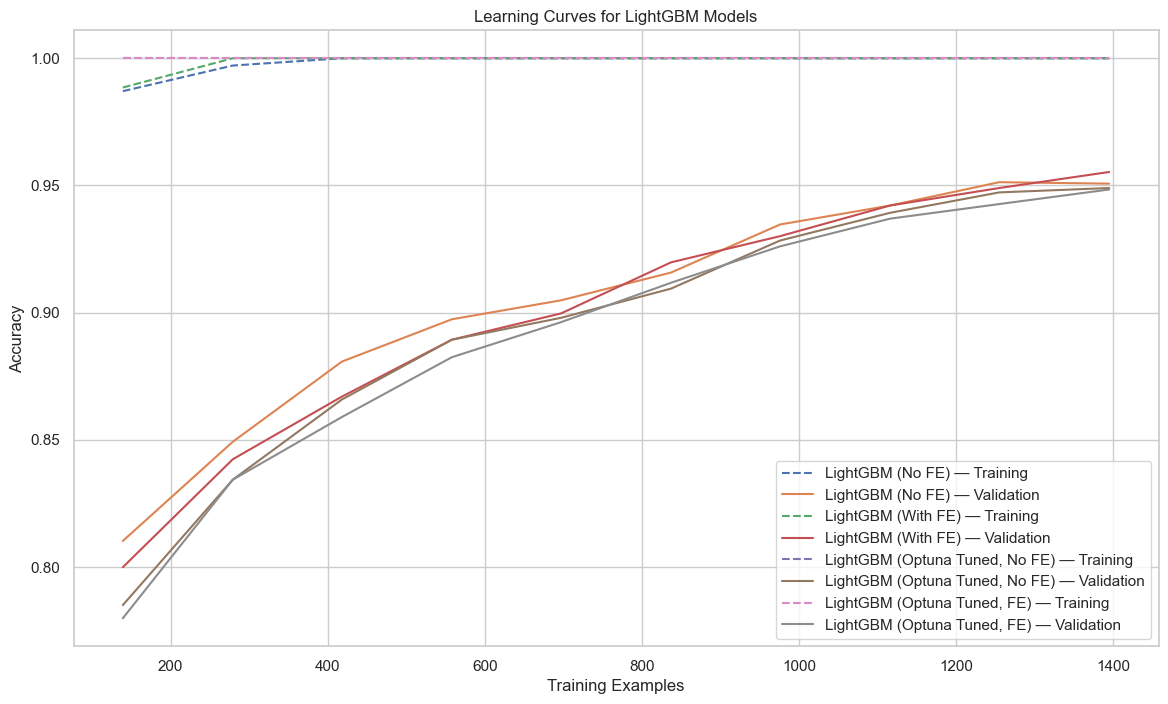

In [26]:
# Build fresh preprocessors
pre_noFE = preprocessor_lightgbm(X_train)      # For raw models
pre_FE   = preprocessor_lightgbm(X_train_fe)   # For FE models

# Dictionary with (model, correct_X)
models = {
    "LightGBM (No FE)": (
        make_pipeline(pre_noFE, LGBMClassifier()),
        X_train
    ),

    "LightGBM (With FE)": (
        make_pipeline(pre_FE, LGBMClassifier()),
        X_train_fe
    ),

    "LightGBM (Optuna Tuned, No FE)": (
        make_pipeline(pre_noFE, LGBMClassifier(**best_params)),
        X_train
    ),

    "LightGBM (Optuna Tuned, FE)": (
        make_pipeline(pre_FE, LGBMClassifier(**best_params_fe)),
        X_train_fe
    ),
}

plt.figure(figsize=(14, 8))

for name, (model, X_input) in models.items():

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_input,
        y=y_train,
        cv=5,
        scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    plt.plot(train_sizes, train_scores.mean(axis=1), "--", label=f"{name} — Training")
    plt.plot(train_sizes, val_scores.mean(axis=1), "-",  label=f"{name} — Validation")

plt.title("Learning Curves for LightGBM Models")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()





Interpretation:
- The **training accuracy** is very high → LightGBM fits the data well.
- **Validation curves converge smoothly**, indicating:
  - low variance,
  - minimal overfitting,
  - model stability even with full dataset.

Comparison shows:
- Optuna tuning yields consistently higher validation accuracy,
- Feature engineering provides no significant generalization benefit.

### ROC Curves

The ROC curve evaluates how well the models separate the two classes across thresholds.

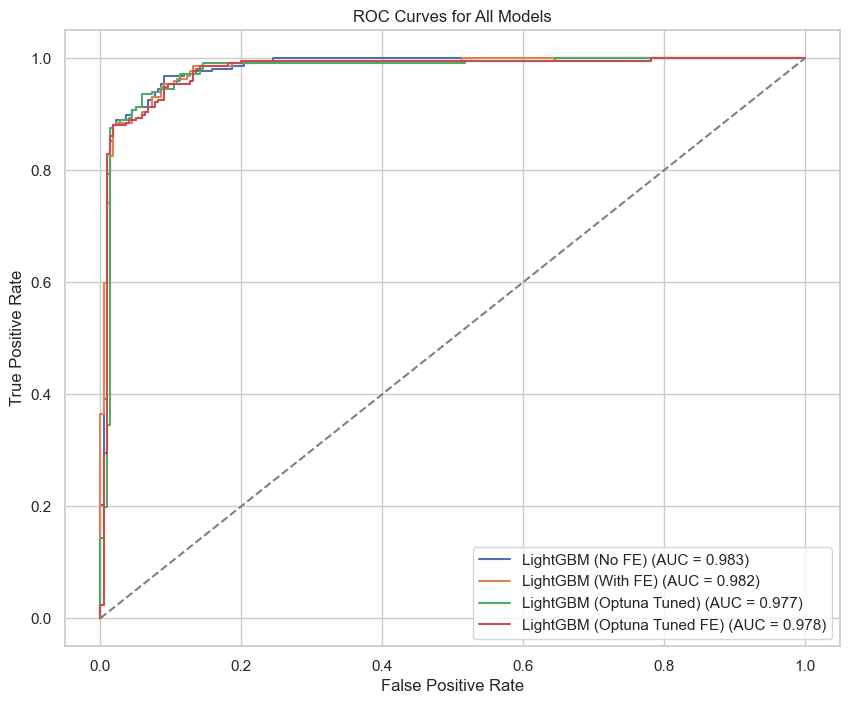

In [27]:
# ROC Curves for all models
roc_models = {
    "LightGBM (No FE)":           (lgbm,                   X_test),
    "LightGBM (With FE)":         (lgbm_fe,                X_test_fe),

    "LightGBM (Optuna Tuned)":    (lgbm_opt,               X_test),
    "LightGBM (Optuna Tuned FE)": (lgbm_opt_fe,            X_test_fe),
}

plt.figure(figsize=(10, 8))

for name, (model, X_input) in roc_models.items():
    y_prob = model.predict_proba(X_input)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray")  # Reference line

plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()




Observations:
- All LightGBM models produce excellent AUC (≥ 0.98),
- The **Optuna-tuned raw model** achieves the best AUC,
- Differences are small but consistent.

High AUC indicates strong true-positive detection with low false positives—important for medical diagnosis tasks.

### Feature Importance

The plot below shows the top 20 most important features used by the LightGBM model **trained with feature engineering**.


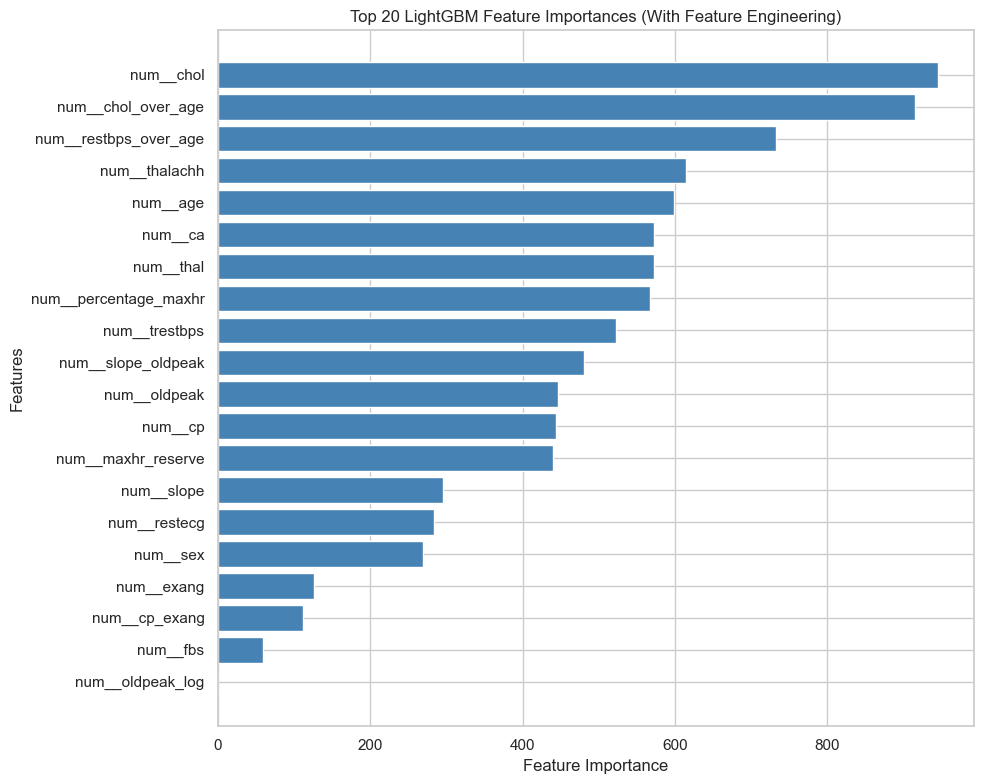

In [28]:
# Extract LightGBM model from the pipeline
model_fe = lgbm_fe.named_steps["model"]

# Extract feature names after preprocessing
feature_names_fe = lgbm_fe.named_steps["preprocess"].get_feature_names_out()

# Extract importances
importances_fe = model_fe.feature_importances_

# Build dataframe and get top 20
df_imp_fe = pd.DataFrame({
    "feature": feature_names_fe,
    "importance": importances_fe
}).sort_values("importance", ascending=False).head(20)

# 5. Plot
plt.figure(figsize=(10, 8))
plt.barh(df_imp_fe["feature"], df_imp_fe["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 20 LightGBM Feature Importances (With Feature Engineering)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Several engineered features appear among the top predictors:

- **chol_over_age** is the **2nd most important feature**
- **restbps_over_age** is the **3rd most important**
- **percentage_maxhr**, **maxhr_reserve**, and **slope_oldpeak** also rank within the top 20

This indicates that the engineered features are **clinically meaningful**, and LightGBM does make use of them.

Even though engineered features are influential, the feature-engineered model still performs **slightly worse** than the LightGBM model trained only on raw features.

This suggests:

- LightGBM already captures nonlinear interactions and ratio-like patterns on its own  
- Adding these manually may introduce **redundancy**  
- Extra engineered features add **slight noise**, which can reduce generalization  
- Feature engineering improves *interpretability*, but does not improve predictive performance in this case

Feature engineering creates sensible, medically relevant predictors and helps understand what drives the predictions.  
However, LightGBM’s strength is that it **naturally learns interactions, thresholds, and nonlinear patterns** directly from raw data.

As a result, the simpler LightGBM model without feature engineering remains the best-performing model.
